In [24]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from CNN2D import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [25]:
gt_train_coord = pickle.load( open( "./import_dataset_2/train/gt_train_coord.pkl", "rb" ) )
gt_train  = pickle.load( open( "./import_dataset_2/train/gt_train.pkl", "rb" ) )
in_train_coord  = pickle.load( open( "./import_dataset_2/train/in_train_coord.pkl", "rb" ) )
inputs_train = pickle.load( open( "./import_dataset_2/train/inputs_train.pkl", "rb" ) )

inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()

gt_train = gt_train.unsqueeze(1) # add 1 dimension to the training set
inputs_train = inputs_train.unsqueeze(1) # add 1 dimension to the training set

inputs_train.shape,gt_train.shape

(torch.Size([5157, 1, 10, 164]), torch.Size([5157, 1, 11, 4]))

## VALIDATION SET

In [26]:
gt_validation_coord = pickle.load( open( "./import_dataset_2/validation/gt_validation_coord.pkl", "rb" ) )
gt_validation = pickle.load( open( "./import_dataset_2/validation/gt_validation.pkl", "rb" ) )
in_validation_coord = pickle.load( open( "./import_dataset_2/validation/in_validation_coord.pkl", "rb" ) )
inputs_validation = pickle.load( open( "./import_dataset_2/validation/inputs_validation.pkl", "rb" ) )

inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()

gt_validation = gt_validation.unsqueeze(1) # add 1 dimension to the training set
inputs_validation = inputs_validation.unsqueeze(1) # add 1 dimension to the training set
print (inputs_validation.shape)

gt_validation_coord.shape,gt_validation.shape,in_validation_coord.shape,inputs_validation.shape

torch.Size([1719, 1, 10, 164])


((11, 1719, 2),
 torch.Size([1719, 1, 11, 4]),
 (10, 1719, 2),
 torch.Size([1719, 1, 10, 164]))

## TEST SET

In [27]:
gt_test_coord_1 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_1.pkl", "rb" ) )
gt_test_1 = pickle.load( open( "./import_dataset_2/test/gt_test_1.pkl", "rb" ) )
in_test_coord_1 = pickle.load( open( "./import_dataset_2/test/in_test_coord_1.pkl", "rb" ) )
inputs_test_1 = pickle.load( open( "./import_dataset_2/test/inputs_test_1.pkl", "rb" ) )

gt_test_coord_2 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_2.pkl", "rb" ) )
gt_test_2 = pickle.load( open( "./import_dataset_2/test/gt_test_2.pkl", "rb" ) )
in_test_coord_2 = pickle.load( open( "./import_dataset_2/test/in_test_coord_2.pkl", "rb" ) )
inputs_test_2 = pickle.load( open( "./import_dataset_2/test/inputs_test_2.pkl", "rb" ) )

gt_test_coord_3 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_3.pkl", "rb" ) )
gt_test_3 = pickle.load( open( "./import_dataset_2/test/gt_test_3.pkl", "rb" ) )
in_test_coord_3 = pickle.load( open( "./import_dataset_2/test/in_test_coord_3.pkl", "rb" ) )
inputs_test_3 = pickle.load( open( "./import_dataset_2/test/inputs_test_3.pkl", "rb" ) )

inputs_test_1 = torch.from_numpy(inputs_test_1).float()
gt_test_1 = torch.from_numpy(gt_test_1).float()
inputs_test_1 = inputs_test_1.unsqueeze(1) 

inputs_test_2 = torch.from_numpy(inputs_test_2).float()
gt_test_2 = torch.from_numpy(gt_test_2).float()
inputs_test_2 = inputs_test_2.unsqueeze(1)

inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()
inputs_test_3 = inputs_test_3.unsqueeze(1)
print (inputs_test_3.shape)

torch.Size([10, 1, 460, 164])


### Model

In [28]:
net = CNN2D()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)

traindataset = utils.TensorDataset(inputs_train, gt_train[:,:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

In [29]:
epochs = 50
steps = 0
running_loss = 0
print_every = 323
loss_train = []
loss_val = []

for e in range(epochs):
    start = time.time()
    steps_bis = 0
    total_train_loss=0
    for train_coord, ground_tru in iter(trainloader):
        
        steps += 1
        steps_bis += 1
        
        #inp = Variable(images)
        #targets = Variable(labels)
        #optimizer.zero_grad()
        #output = net.forward(inp)
        #loss = criterion(output, targets.view(-1,40))
        #grad = loss.backward()
        #optimizer.step()
        #running_loss += loss.item()

        input_train = Variable(train_coord)
        in_train = input_train.squeeze(1)
        target = Variable(ground_tru)
        targets = target.squeeze(1)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        out = net.forward(input_train)
        out = out.reshape(out.shape[0],10,4)
        out_bis = out[:,:,0:2].clone()
        #print(out_bis.shape)   
        for i in range(10):
            if i == 0:
                out_bis[:, i, 0:2] = in_train[:, -1, 0:2] + out[:, i, 2:]*0.4
            else:
                out_bis[:, i, 0:2] = out[:, i - 1, 0:2] + out[:, i, 2:]*0.4
        #pdb.set_trace()
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        loss2 = (criterion(out[:,:,2:], targets[:,:,2:]))
        loss3 = criterion(out_bis, targets[:,:,0:2])
        
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += (loss1+loss2+loss3).item()
        total_train_loss += (loss1+loss2+loss3).item()
        
        if steps % print_every == 0:
            stop = time.time()
            val_loss=0
            
            for ii, (images, labels) in enumerate(valloader):
                
                inp = Variable(images)
                input_val = inp.squeeze(1)
                lab = Variable(labels)
                valgt = lab.squeeze(1)
                predicted = net.predict(inp)
                predicted = predicted.reshape(predicted.shape[0],10,4)
                predicted_bis = predicted[:,:,0:2].clone()
                #print(out_bis.shape)   
                for i in range(10):
                    if i == 0:
                        predicted_bis[:, i, 0:2] = input_val[:, -1, 0:2] + predicted[:, i, 2:]*0.4
                    else:
                        predicted_bis[:, i, 0:2] = predicted[:, i - 1, 0:2] + predicted[:, i, 2:]*0.4
                val_loss+= (criterion(predicted[:,:,0:2],valgt[:,:,0:2]).item()
                                + criterion(predicted[:,:,2:],valgt[:,:,2:]).item()
                                + criterion(predicted_bis, valgt[:,:,0:2]).item())
                
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation Loss: {:.4f}..".format(val_loss/ii),
                  "Training Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                 )
            loss_val.append(val_loss/ii)
            running_loss = 0
            start = time.time()
    loss_train.append(total_train_loss/steps_bis)

Epoch: 1/50.. Validation Loss: 5.5494.. Training Loss: 8.1477.. 0.0218 s/batch 
Epoch: 2/50.. Validation Loss: 4.2113.. Training Loss: 4.7882.. 0.0241 s/batch 
Epoch: 3/50.. Validation Loss: 3.3828.. Training Loss: 3.7519.. 0.0220 s/batch 
Epoch: 4/50.. Validation Loss: 2.8370.. Training Loss: 2.9979.. 0.0238 s/batch 
Epoch: 5/50.. Validation Loss: 2.4256.. Training Loss: 2.4862.. 0.0245 s/batch 
Epoch: 6/50.. Validation Loss: 2.2243.. Training Loss: 2.1881.. 0.0202 s/batch 
Epoch: 7/50.. Validation Loss: 2.0350.. Training Loss: 2.0139.. 0.0207 s/batch 
Epoch: 8/50.. Validation Loss: 1.9816.. Training Loss: 1.8750.. 0.0199 s/batch 
Epoch: 9/50.. Validation Loss: 1.8737.. Training Loss: 1.8077.. 0.0193 s/batch 
Epoch: 10/50.. Validation Loss: 1.8444.. Training Loss: 1.7440.. 0.0222 s/batch 
Epoch: 11/50.. Validation Loss: 1.9449.. Training Loss: 1.6814.. 0.0204 s/batch 
Epoch: 12/50.. Validation Loss: 1.7064.. Training Loss: 1.5925.. 0.0194 s/batch 
Epoch: 13/50.. Validation Loss: 1.662

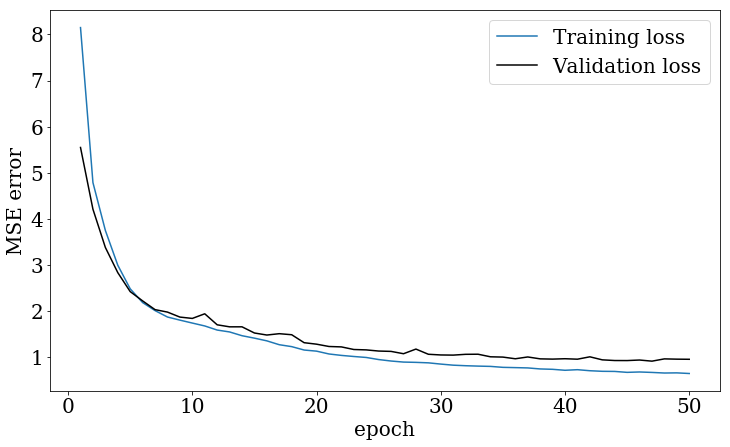

In [30]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()

In [32]:
output_test_1 = net.predict(inputs_test_1)
output_test_1 = output_test_1.data.numpy()
output_test_1 = np.reshape(output_test_1,(250,10,4))

output_test_2 = net.predict(inputs_test_2)
output_test_2 = output_test_2.data.numpy()
output_test_2 = np.reshape(output_test_2,(1006,10,4))

output_test_3 = net.predict(inputs_test_3)
output_test_3 = output_test_3.data.numpy()
output_test_3 = np.reshape(output_test_3,(460,10,4))

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

##### Type 1 trajectory

In [34]:
output_coord_1=np.zeros([11,inputs_test_1.shape[2],2])
print(output_test_1.shape)
for j in range(11):
    for i in range(output_test_1.shape[2]):
        if j==0:
            output_coord_1[j,i,0:2] = in_test_coord_1[9,i,0:2]
        else:
            output_coord_1[j,i,0:2] = output_coord_1[j-1,i,0:2]+output_test_1[i,j-1,2:]*0.4
        

(250, 10, 4)


In [35]:
dist = np.zeros(inputs_test_1.shape[2])
for i in range(inputs_test_1.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_1[10,i,:]-output_coord_1[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 0.632


In [36]:
avr = np.zeros((inputs_test_1.shape[2],11))
for i in range(inputs_test_1.shape[2]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_1[j,i,:]-output_coord_1[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.5


(-0.1485349642969668,
 0.9192342502363027,
 -0.19455222731828692,
 4.085596773684025)

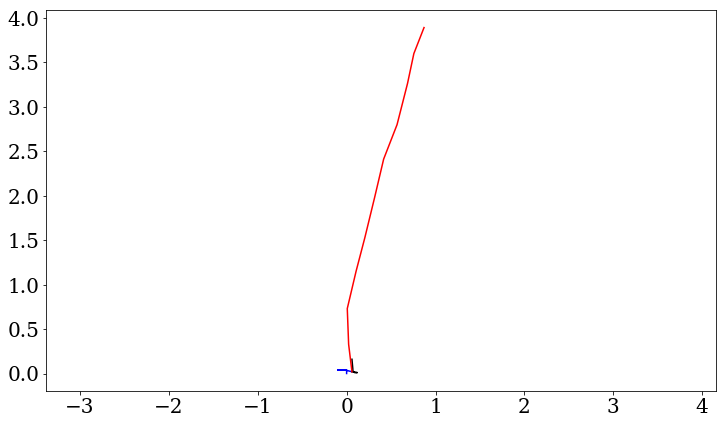

In [37]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_1.shape[1])

plt.plot(in_test_coord_1[:,ind,0],in_test_coord_1[:,ind,1],c='b')
plt.plot(gt_test_coord_1[:,ind,0],gt_test_coord_1[:,ind,1],c='k')
plt.plot(output_coord_1[:,ind,0],output_coord_1[:,ind,1],c='r')
plt.axis('equal')

In [39]:
output_coord_2=np.zeros([11,inputs_test_2.shape[2],2])
for j in range(11):
    for i in range(output_test_2.shape[2]):
        if j==0:
            output_coord_2[j,i,0:2] = in_test_coord_2[9,i,0:2]
        else:
            output_coord_2[j,i,0:2] = output_coord_2[j-1,i,0:2]+output_test_2[i,j-1,2:]*0.4
        

In [40]:
dist = np.zeros(inputs_test_2.shape[2])
for i in range(inputs_test_2.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_2[10,i,:]-output_coord_2[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 7.018


In [41]:
avr = np.zeros((inputs_test_2.shape[1],11))
for i in range(inputs_test_2.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_2[j,i,:]-output_coord_2[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 2.278


(-0.14057850045051956, 2.952148509460911, -0.5169107140000001, 10.855124994)

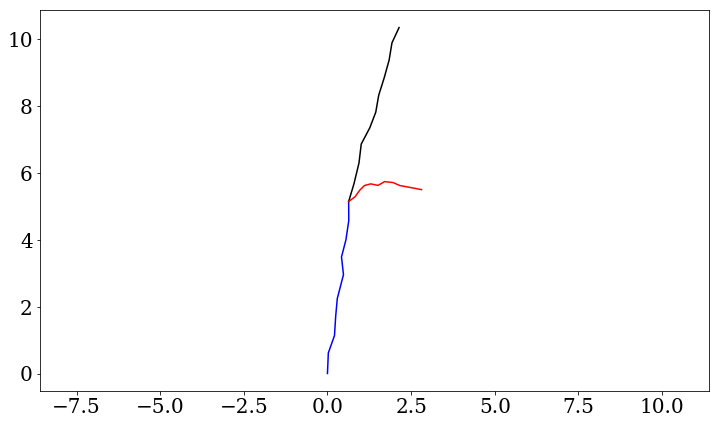

In [42]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_2.shape[1])

plt.plot(in_test_coord_2[:,ind,0],in_test_coord_2[:,ind,1],c='b')
plt.plot(gt_test_coord_2[:,ind,0],gt_test_coord_2[:,ind,1],c='k')
plt.plot(output_coord_2[:,ind,0],output_coord_2[:,ind,1],c='r')
plt.axis('equal')

In [43]:
output_coord_3=np.zeros([11,inputs_test_3.shape[2],2])
for j in range(11):
    for i in range(output_test_3.shape[2]):
        if j==0:
            output_coord_3[j,i,0:2] = in_test_coord_3[9,i,0:2]
        else:
            output_coord_3[j,i,0:2] = output_coord_3[j-1,i,0:2]+output_test_3[i,j-1,2:]*0.4
        

In [44]:
dist = np.zeros(inputs_test_3.shape[2])
for i in range(inputs_test_3.shape[2]):
    dist[i] = np.sqrt(sum((gt_test_coord_3[10,i,:]-output_coord_3[10,i,:])**2))

final_coord_error = np.mean(dist)
print('The final distance between the ground trought and the predicted coordinates is :',final_coord_error.round(3))

The final distance between the ground trought and the predicted coordinates is : 4.968


In [45]:
avr = np.zeros((inputs_test_3.shape[1],11))
for i in range(inputs_test_3.shape[1]):
    for j in range(11):
        avr[i,j] = np.sqrt(sum((gt_test_coord_3[j,i,:]-output_coord_3[j,i,:])**2))

average = np.mean(np.mean(avr,1))
print('The average error between the ground trought and the predicted coordinates is :',average.round(3))

The average error between the ground trought and the predicted coordinates is : 0.77


(-0.40725626131556497,
 0.8160443324435983,
 -0.40624830404911044,
 8.53121438503132)

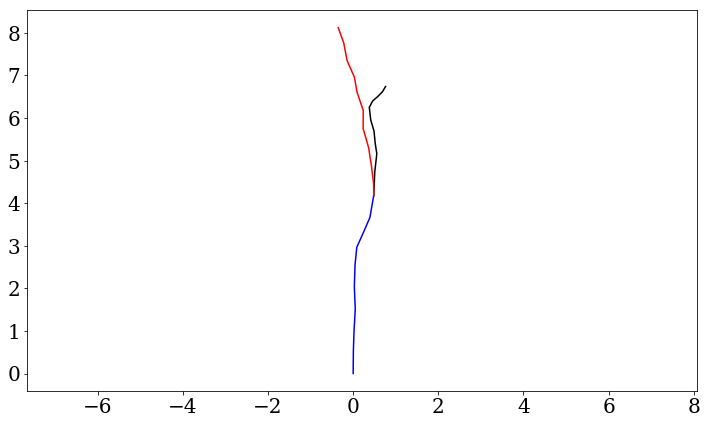

In [46]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = np.random.randint(inputs_test_3.shape[0])

plt.plot(in_test_coord_3[:,ind,0],in_test_coord_3[:,ind,1],c='b')
plt.plot(gt_test_coord_3[:,ind,0],gt_test_coord_3[:,ind,1],c='k')
plt.plot(output_coord_3[:,ind,0],output_coord_3[:,ind,1],c='r')
plt.axis('equal')

In [47]:
torch.save(net.state_dict(), 'fullCNN_4.pt')